In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
#import Image
import sys
import os
from  math import pow
from PIL import Image, ImageDraw, ImageFont
import cv2
import math
import random
caffe_root = '/home/matt/Documents/caffe/'

sys.path.insert(0, caffe_root + 'python')
os.environ['GLOG_minloglevel'] = '2'
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()


In [67]:
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def range_overlap(a_min, a_max, b_min, b_max):

    return (a_min <= b_max) and (b_min <= a_max)

def rect_overlaps(r1,r2):
    return range_overlap(r1.left, r1.right, r2.left, r2.right) and range_overlap(r1.bottom, r1.top, r2.bottom, r2.top)

def rect_merge(r1,r2, mergeThresh):

    if rect_overlaps(r1,r2):
        # dist = calculateDistance((r1.left + r1.right)/2, (r1.top + r1.bottom)/2, (r2.left + r2.right)/2, (r2.top + r2.bottom)/2)
        SI= abs(min(r1.right, r2.right) - max(r1.left, r2.left)) * abs(max(r1.bottom, r2.bottom) - min(r1.top, r2.top))
        SA = abs(r1.right - r1.left)*abs(r1.bottom - r1.top)
        SB = abs(r2.right - r2.left)*abs(r2.bottom - r2.top)
        S=SA+SB-SI
        ratio = float(SI) / float(S)
        if ratio > mergeThresh :
            return 1
    return 0
class Rect(object):
    def __init__(self, p1, p2):
        '''Store the top, bottom, left and right values for points
               p1 and p2 are the (corners) in either order
        '''
        self.left   = min(p1.x, p2.x)
        self.right  = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top    = max(p1.y, p2.y)

    def __str__(self):
        return "Rect[%d, %d, %d, %d]" % ( self.left, self.top, self.right, self.bottom )
def nms_average(boxes, groupThresh=2, overlapThresh=0.2):
    rects = []
    temp_boxes = []
    weightslist = []
    new_rects = []
    for i in range(len(boxes)):
        if boxes[i][4] > 0.2:
            rects.append([boxes[i,0], boxes[i,1], boxes[i,2]-boxes[i,0], boxes[i,3]-boxes[i,1]])


    rects, weights = cv2.groupRectangles(rects, groupThresh, overlapThresh)

    rectangles = []
    for i in range(len(rects)):

        testRect = Rect( Point(rects[i,0], rects[i,1]), Point(rects[i,0]+rects[i,2], rects[i,1]+rects[i,3]))
        rectangles.append(testRect)
    clusters = []
    for rect in rectangles:
        matched = 0
        for cluster in clusters:
            if (rect_merge( rect, cluster , 0.2) ):
                matched=1
                cluster.left   =  (cluster.left + rect.left   )/2
                cluster.right  = ( cluster.right+  rect.right  )/2
                cluster.top    = ( cluster.top+    rect.top    )/2
                cluster.bottom = ( cluster.bottom+ rect.bottom )/2

        if ( not matched ):
            clusters.append( rect )
    result_boxes = []
    for i in range(len(clusters)):

        result_boxes.append([clusters[i].left, clusters[i].bottom, clusters[i].right, clusters[i].top, 1])

    return result_boxes


In [68]:
def generateBoundingBox(featureMap, scale):
    boundingBox = []
    stride = 32
    cellSize = 227

    for (x,y), prob in np.ndenumerate(featureMap):
        if(prob >= 0.95):
            boundingBox.append([float(stride * y)/ scale, 
                                float(x * stride)/scale, 
                                float(stride * y + cellSize - 1)/scale, 
                                float(stride * x + cellSize - 1)/scale, prob])

    return boundingBox

In [74]:
def face_detection(imgFile):
    net_full_conv = caffe.Net(os.path.join(caffe_root, 'faceDetect', 'deploy_full_conv.prototxt'),
                              os.path.join(caffe_root, 'faceDetect', 'alexnet_iter_50000_full_conv.caffemodel'),
                              caffe.TEST)
    randNum = random.randint(1,10000)
    
    
    
    scales = []
    factor = 0.793700526

    
    img = cv2.imread(imgFile)

    
    largest = min(2, 4000/max(img.shape[0:2]))
    scale = largest
    minD = largest*min(img.shape[0:2])
    while minD >= 227:
        scales.append(scale)
        scale *= factor
        minD *= factor

    total_boxes = []

    for scale in scales:

        scale_img = cv2.resize(img,((int(img.shape[0] * scale), int(img.shape[1] * scale))))
        cv2.imwrite('/home/admin01/scale_img.jpg',scale_img)

        im = caffe.io.load_image('/home/admin01/scale_img.jpg')
        net_full_conv.blobs['data'].reshape(1,3,scale_img.shape[1],scale_img.shape[0])
        transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
        transformer.set_mean('data', np.load(caffe_root +
                                             'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
        transformer.set_transpose('data', (2,0,1))
        transformer.set_channel_swap('data', (2,1,0))
        transformer.set_raw_scale('data', 255.0)
        
        out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
        
        boxes = generateBoundingBox(out['prob'][0,1], scale)
        if(boxes):
            total_boxes.extend(boxes)

    boxes_nms = np.array(total_boxes)
    true_boxes = nms_average(boxes_nms, 1, 0.2)
    if not true_boxes == []:
        (x1, y1, x2, y2) = true_boxes[0][:-1]
        print (x1, y1, x2, y2)
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
        cv2.imwrite('/home/admin01/51CTO/notebook/result.jpg',img)

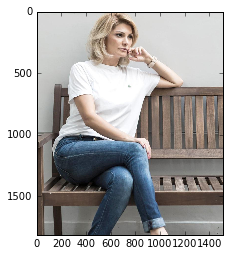

In [75]:
imgFile = '/home/admin01/51CTO/notebook/tmp9055.jpg'
#image_file = cbook.get_sample_data(imgFile)
img = plt.imread(imgFile)
plt.imshow(img)
plt.show()

#face_detection(imgFile)

In [76]:
face_detection(imgFile)

(1, 2, 108, 89)
(108, 89)
(2, 108, 89)


IndexError: index 1 is out of bounds for axis 0 with size 1

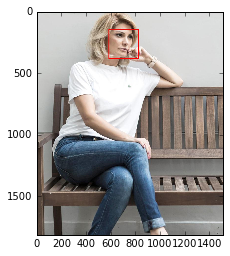

In [72]:
imgFile = '/home/admin01/51CTO/notebook/result.jpg'
img = plt.imread(imgFile)
plt.imshow(img)
plt.show()